<a href="https://colab.research.google.com/github/ainurafifah00/Coursera_TF/blob/master/%5BCNN%5D_Week_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using more sophisticated images with Convolutional Neural Networks

In the previous lesson you saw how to use a CNN to make your recognition of the handwriting digits more efficient. In this lesson you'll take that to the next level, recognizing real images of Cats and Dogs in order to classify an incoming image as one or the other. In particular the handwriting recognition made your life a little easier by having all the images be the same size and shape, and they were all monochrome color. Real-world images aren't like that -- they're in different shapes, aspect ratios etc, and they're usually in color!

So, as part of the task you need to process your data -- not least resizing it to be uniform in shape. 

You'll follow these steps:

1.   Explore the Example Data of Cats and Dogs
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

## Explore the Example Data

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2020-02-05 08:17:07--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   109MB/s    in 0.6s    

2020-02-05 08:17:08 (109 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets. Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'cats' directory and a 'dogs' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [11]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.379.jpg', 'cat.525.jpg', 'cat.60.jpg', 'cat.594.jpg', 'cat.438.jpg', 'cat.917.jpg', 'cat.105.jpg', 'cat.706.jpg', 'cat.344.jpg', 'cat.713.jpg']
['dog.571.jpg', 'dog.505.jpg', 'dog.661.jpg', 'dog.597.jpg', 'dog.486.jpg', 'dog.116.jpg', 'dog.242.jpg', 'dog.174.jpg', 'dog.211.jpg', 'dog.683.jpg']


In [12]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [0]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

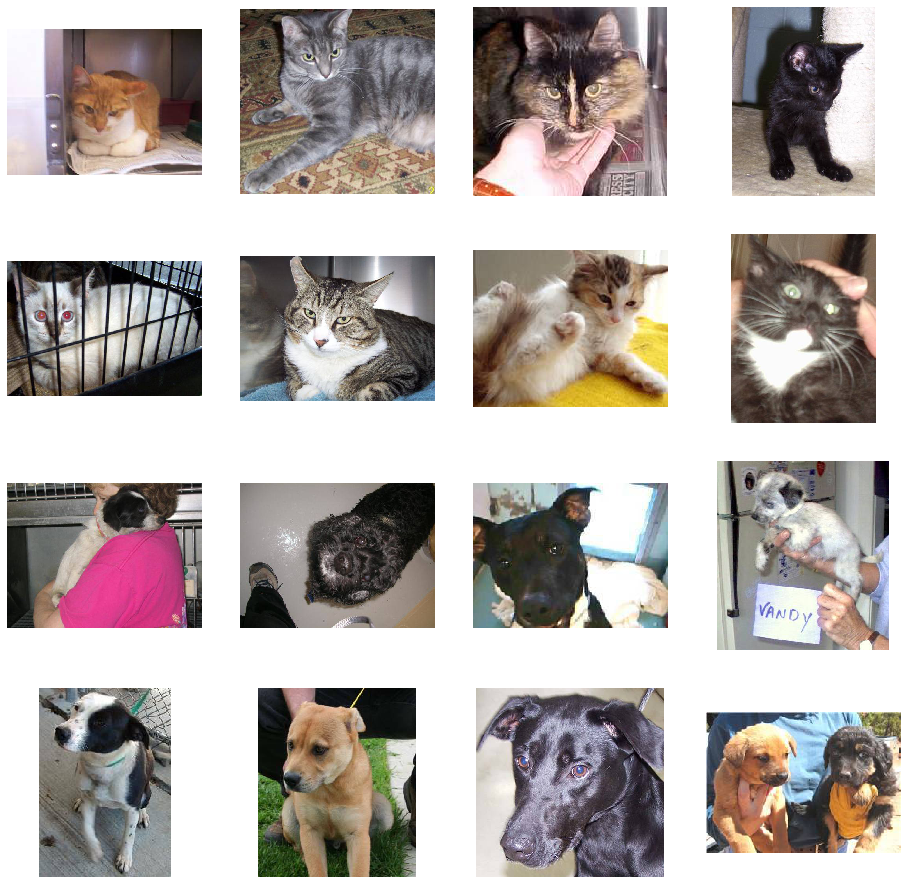

In [14]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building a Small Model from Scratch to Get to ~72% Accuracy

In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. We've chosen 150x150 for this, and you'll see the code that preprocesses the images to that shape shortly. 

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

Next we will define a Sequential layer as before, adding some convolutional layers first. Note the input shape parameter this time. It is 150x150 for the size and 3 (24 bits, 3 bytes) for the color depth. 

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [15]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0